In [1]:
import graspologic

import numpy as np
import matplotlib.pyplot as plt

/opt/hostedtoolcache/Python/3.8.13/x64/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Padded Graph Matching
Consider the scenario where one would like to match graphs $A$ and $B$ with $n_1$ and $n_2$ nodes, respectively, where 
$n_1 < n_2$. The most straightforward fashion to 'pad' $A$, such that $A$ and $B$ have the same shape, is to add $n_2 - n_1$ isolated nodes to $A$ (represented as empty row/columns in the adjacency matrix). This padding scheme is known as $\textit{naive padding}$, substituting $A \oplus 0_{(n_2-n_1)x(n_2-n_1)}$ and $B$ in place of $A$ and $B$, respectively.

The effect of this is that one matches $A$ to the best subgraph of $B$. That is, the isolated vertices added to $A$ through padding have an affinity to the low-density subgraphs of $B$, in effect giving the isolates a false signal.  

Instead, we may desire to match $A$ to the best fitting induced subgraph of $B$. This padding scheme is known as $\textit{adopted padding}$, and is achieved by substituting $\tilde{A} \oplus 0_{(n_2-n_1)x(n_2-n_1)}$ and $\tilde{B}$ in place of $A$ and $B$, respectively, where $\tilde{A} = 2A - 1_{n_1}1_{n_1}^T$ and $\tilde{B} = 2B - 1_{n_2}1_{n_2}^T$.


To demonstrate the difference between the two padding schemes, we sample two graph's $G_1'$ and $G_2$, each having 400 vertices, from a $0.5 \sim SBM(4,b,\Lambda)$, where b assigns 100 vertices to each of the k = 4 blocks, and

\begin{align*}
\Lambda &= \begin{bmatrix} 
0.9 & 0.4 & 0.3 & 0.2\\
0.4 & 0.9 & 0.4 & 0.3\\
0.3 & 0.4 & 0.9 & 0.4\\
0.2 & 0.3 & 0.4 & 0.7
\end{bmatrix}\\
\end{align*}

We realize $G_1$ from $G_1'$ by removing 25 nodes from each block of $G_1'$, yielding a 300 node graph (example adapted from section 2.5 of [1]).

The goal of the matching in this case is to recover $G_1$ by matching the right most figure below and $G_2$. That is, we seek to recover the shared community structure common between two graphs of differing shapes.

<a id="1">[1]</a> 
D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski, C. Priebe,
        "Seeded graph matching", Pattern Recognit. 87 (2019) 203–215

## SBM correlated graph pairs

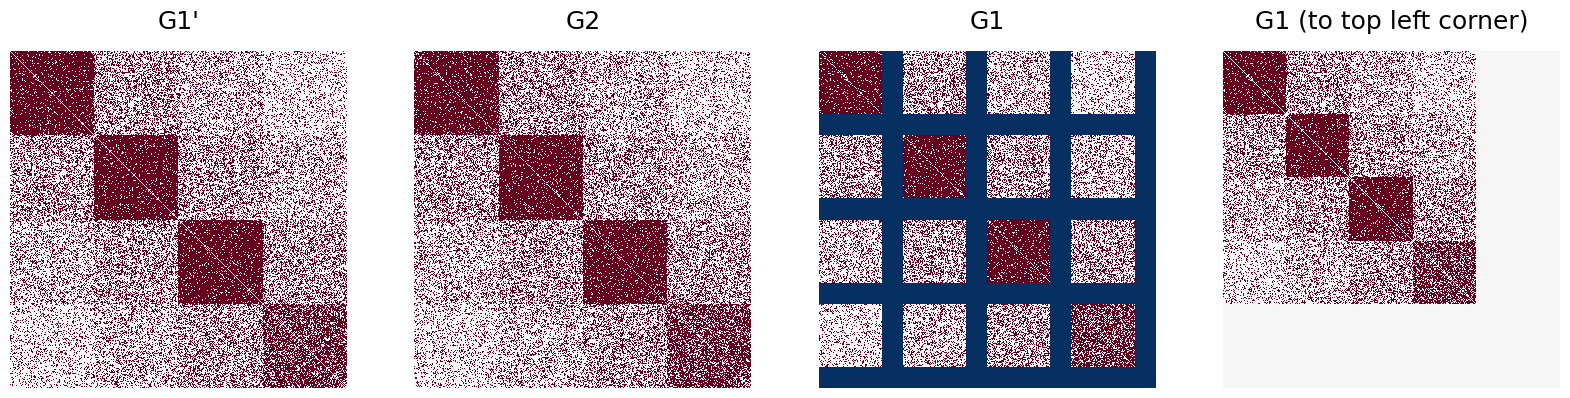

In [2]:
# simulating G1', G2, deleting 25 vertices
from graspologic.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
from graspologic.plot import heatmap
np.random.seed(1)

directed = False
loops = False
block_probs = [[0.9,0.4,0.3,0.2],
                [0.4,0.9,0.4,0.3],
                [0.3,0.4,0.9,0.4],
                [0.2,0.3,0.4,0.7]]
n =100
n_blocks = 4
rho = 0.5
block_members = np.array(n_blocks * [n])
n_verts = block_members.sum()
G1p, G2 = sbm_corr(block_members,block_probs, rho, directed, loops)
G1 = np.zeros((300,300))
c = np.copy(G1p)

step1 = np.arange(4) * 100 + 75
step2 = np.arange(5) * 75
step3 = np.arange(4) * 100
for i in range(len(step1)):
    block1 = np.arange(step1[i], step1[i]+25)
    c[block1,:] = -1
    c[:, block1] = -1
    for j in range(len(step3)):
        G1[step2[i]:step2[i+1], step2[j]:step2[j+1]] = G1p[step3[i]: step1[i], step3[j]:step1[j]]
        
topleft_G1 = np.zeros((400,400))
topleft_G1[:300,:300] = G1
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
heatmap(G1p, ax=axs[0], cbar=False, title="G1'")
heatmap(G2, ax=axs[1], cbar=False, title="G2")
heatmap(c, ax=axs[2], cbar=False, title="G1")
_ = heatmap(topleft_G1, ax=axs[3], cbar=False, title="G1 (to top left corner)")

## Naive vs Adopted Padding

Match ratio of nodes remaining in G1, with naive padding: 0.09666666666666666
Match ratio of nodes remaining in G1, with adopted padding: 1.0


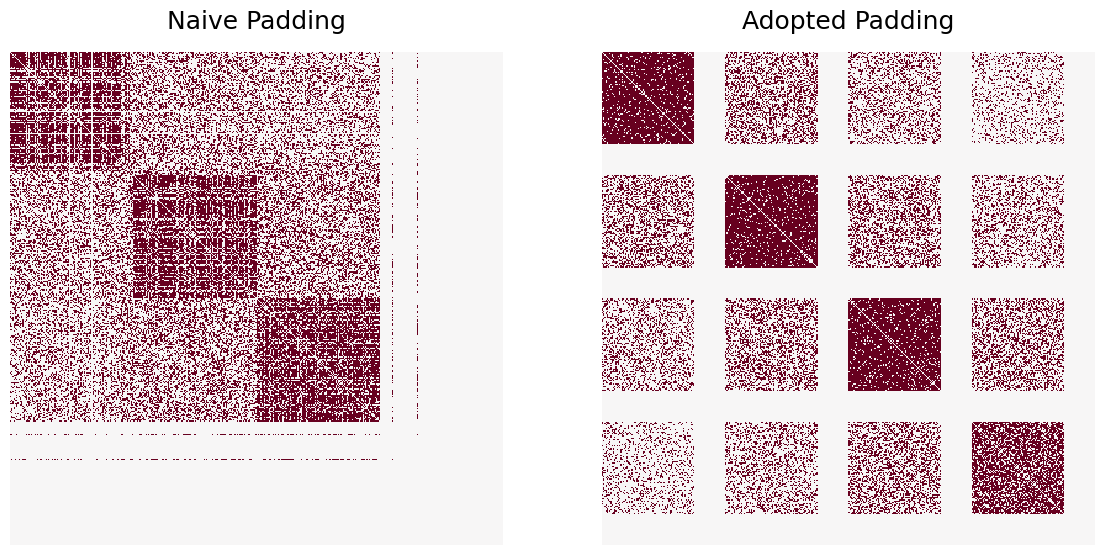

In [3]:
np.random.seed(1)

gmp_naive = GMP(padding='naive')
seed1 = np.random.choice(np.arange(300),8)
seed2 = [int(x/75)*25 + x for x in seed1]
gmp_naive = gmp_naive.fit(G2, G1, seed2, seed1)
G1_naive = topleft_G1[gmp_naive.perm_inds_][:, gmp_naive.perm_inds_]

gmp_adopted = GMP(padding='adopted')
gmp_adopted = gmp_adopted.fit(G2, G1, seed2, seed1)
G1_adopted = topleft_G1[gmp_adopted.perm_inds_][:, gmp_adopted.perm_inds_]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
heatmap(G1_naive, ax=axs[0], cbar=False, title="Naive Padding")
heatmap(G1_adopted, ax=axs[1], cbar=False, title="Adopted Padding")

naive_matching = np.concatenate([gmp_naive.perm_inds_[x * 100 : (x * 100) + 75] for x in range(n_blocks)])
adopted_matching = np.concatenate([gmp_adopted.perm_inds_[x * 100 : (x * 100) + 75] for x in range(n_blocks)])

print(f'Match ratio of nodes remaining in G1, with naive padding: {sum(naive_matching == np.arange(300))/300}')
print(f'Match ratio of nodes remaining in G1, with adopted padding: {sum(adopted_matching == np.arange(300))/300}')

We observe that the two padding schemes perform as expected. The naive scheme permutes $G_1$ such that it matches a subgraph of $G_2$, specifically the subgraph of the first three blocks. Additionally, (almost) all isolated vertices of $G_1$ are permuted to the fourth block of $G_2$.

On the other hand, we see that adopted padding preserves the common block structure between $G_1$ and $G_2$.